### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from collections import Counter
import model_evaluation_utils as meu
from scipy.stats import boxcox # data transform

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, 
                                     GridSearchCV, RandomizedSearchCV, learning_curve, validation_curve)
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from kmodes import kmodes

from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, BatchNormalization

Using TensorFlow backend.


### Data Loading

In [2]:
train_df = pd.read_csv('data/train.csv')
print(train_df.shape)
train_df.head()

(116058, 29)


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


In [3]:
test_df = pd.read_csv('data/test.csv')
print(test_df.shape)
test_df.head()

(35866, 28)


,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,...,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,...,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,...,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,...,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,...,0,0,0,0,0,0,0,0,0,0


### Date Column Preprocessing

In [4]:
train_df['origination_month'] = train_df['origination_date'].apply(lambda x : int(x.split('-')[1]))
train_df['first_payment_month'] = train_df['first_payment_date'].apply(lambda x : int(x.split('/')[0]))
train_df = train_df.drop(['origination_date','first_payment_date'], axis=1)

test_df['origination_month'] = test_df['origination_date'].apply(lambda x : int(x.split('/')[1]))
test_df['first_payment_month'] = test_df['first_payment_date'].apply(lambda x : x.split('-')[0])
test_df['first_payment_month'] = test_df['first_payment_month'].map({'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5, 'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11})
test_df = test_df.drop(['origination_date','first_payment_date'], axis=1)

### EDA

#### Categorical Features

In [5]:
train_df.groupby(['source','m13'])['m13'].count()

source  m13
X       0      63553
        1        305
Y       0      37307
        1        247
Z       0      14562
        1         84
Name: m13, dtype: int64

In [6]:
train_df.groupby(['loan_purpose','m13'])['m13'].count()

loan_purpose  m13
A23           0      58251
              1        211
B12           0      29164
              1        219
C86           0      28007
              1        206
Name: m13, dtype: int64

In [7]:
train_df.groupby(['insurance_type','m13'])['m13'].count()

insurance_type  m13
0.0             0      115049
                1         631
1.0             0         373
                1           5
Name: m13, dtype: int64

In [8]:
train_df.groupby(['number_of_borrowers','m13'])['m13'].count()

number_of_borrowers  m13
1.0                  0      46787
                     1        427
2.0                  0      68635
                     1        209
Name: m13, dtype: int64

In [9]:
train_df.groupby(['loan_term'])['loan_term'].count()

loan_term
60         6
71         1
72         2
77         1
78         1
81         1
82         1
83         1
84        21
85         1
86         1
87         3
88         1
89         1
91         1
93         1
94         1
96       178
100        1
102        2
107        1
108       29
110        1
111        1
115        1
120     7061
121       14
132       19
134        3
135        2
       ...  
326        2
327        3
328        4
329        3
330        4
331        4
332        3
333        3
334        4
335        1
336       64
338        2
339        2
340        4
341        1
342        3
343        2
344        1
345        3
347        1
348       33
349        1
351        1
352        4
353        2
354        2
355        4
358        1
359        1
360    71812
Name: loan_term, Length: 140, dtype: int64

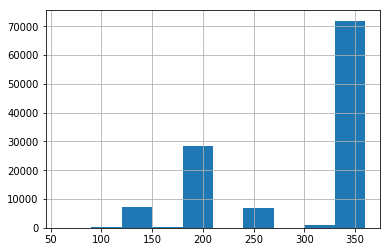

In [10]:
train_df['loan_term'].hist()

In [11]:
train_df['loan_term_bin'] = train_df['loan_term'].apply(lambda x : 1 if x > 180 else 0)

In [12]:
train_df.groupby(['financial_institution','m13'])['m13'].count()

financial_institution        m13
Anderson-Taylor              0        480
                             1          3
Browning-Hart                0      31677
                             1        175
Chapman-Mcmahon              0        388
Cole, Brooks and Vincent     0       1630
                             1         12
Edwards-Hoffman              0       4816
                             1         41
Martinez, Duffy and Bird     0       4692
                             1         23
Miller, Mcclure and Allen    0       3139
                             1         19
Nicholson Group              0       2105
                             1         11
OTHER                        0      49430
                             1        269
Richards-Walters             0       1454
                             1          5
Richardson Ltd               0        472
                             1          1
Romero, Woods and Johnson    0        748
                             1          2
S

In [13]:
def fin_ins_transform(value):
    if value == 'Browning-Hart':
        return 0
    elif value == 'OTHER':
        return 1
    elif value == 'Edwards-Hoffman' or value == 'Swanson, Newton and Miller':
        return 2
    else:
        return 3
    
train_df['financial_institution_bin'] = train_df['financial_institution'].apply(fin_ins_transform)

In [14]:
train_df.groupby(['financial_institution_bin','m13'])['m13'].count()

financial_institution_bin  m13
0                          0      31677
                           1        175
1                          0      49430
                           1        269
2                          0      11644
                           1         87
3                          0      22671
                           1        105
Name: m13, dtype: int64

In [15]:
train_df.groupby(['origination_month','m13'])['m13'].count()

origination_month  m13
1                  0      48789
                   1        304
2                  0      52055
                   1        279
3                  0      14578
                   1         53
Name: m13, dtype: int64

In [16]:
train_df.groupby(['first_payment_month','m13'])['m13'].count()

first_payment_month  m13
2                    0        518
                     1          6
3                    0      47384
                     1        296
4                    0      52560
                     1        280
5                    0      14960
                     1         54
Name: m13, dtype: int64

In [17]:
train_df.groupby(['insurance_percent','m13'])['m13'].count()

insurance_percent  m13
0.0                0      101909
                   1         546
6.0                0         695
                   1           6
12.0               0        2479
                   1          14
15.0               0           1
16.0               0          18
17.0               0           2
18.0               0          12
20.0               0           3
22.0               0           1
25.0               0        4855
                   1          30
30.0               0        5076
                   1          37
35.0               0         369
                   1           3
39.0               0           1
40.0               0           1
Name: m13, dtype: int64

In [18]:
def ins_prc_transform(value):
    if value < 25.0:
        return 0
    else:
        return 1
    
train_df['insurance_percent_bin'] = train_df['insurance_percent'].apply(ins_prc_transform)

In [19]:
train_df['insurance_percent_bin'].value_counts()

0    105686
1     10372
Name: insurance_percent_bin, dtype: int64

#### Numerical Features

In [20]:
num_var = ['interest_rate','unpaid_principal_bal','loan_to_value','debt_to_income_ratio', 'borrower_credit_score','co-borrower_credit_score']

for var in num_var:
    train_df[var+'_bin'] = pd.qcut(train_df[var], 6, labels=False, duplicates='drop')
    #test_df[var+'_cat'] = pd.qcut(test_df[var], 6, labels=False, duplicates='drop')    

In [21]:
num_cols = ['interest_rate_bin','unpaid_principal_bal_bin','loan_to_value_bin','debt_to_income_ratio_bin',\
           'borrower_credit_score_bin','co-borrower_credit_score_bin']
train_df[num_cols].head()

,interest_rate_bin,unpaid_principal_bal_bin,loan_to_value_bin,debt_to_income_ratio_bin,borrower_credit_score_bin,co-borrower_credit_score_bin
0,4,3,5,1,0,0
1,5,2,2,5,0,0
2,0,5,0,3,2,0
3,5,1,0,5,0,0
4,5,1,4,5,0,0


##### Chi-Square test for Categorical vs Target(Categorical) features

In [22]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

df = pd.crosstab(train_df['co-borrower_credit_score_bin'], train_df['m13'])
print(df.head(2))

# contingency table
stat, p, dof, expected = chi2_contingency(df)
print('dof=%d' % dof)
print(expected)

# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

m13                               0    1
co-borrower_credit_score_bin            
0                             57577  542
1                             19922   47
dof=3
[[57800.50679832   318.49320168]
 [19859.56950835   109.43049165]
 [19480.65739544   107.34260456]
 [18281.26629789   100.73370211]]
probability=0.950, critical=7.815, stat=319.178
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


In [23]:
#Dependent = ['source', 'loan_purpose', 'number_of_borrowers', 'loan_term_bin', 'financial_institution_bin', \
#                'origination_month', 'first_payment_month', 'insurance_percent_bin', 'interest_rate_bin',\
#                'unpaid_principal_bal_bin','loan_to_value_bin','debt_to_income_ratio_bin',\
#                'borrower_credit_score_bin','co-borrower_credit_score_bin']

#Independent = ['insurance_type', 'loan_term', 'financial_institution']

### Data Preprocessing

##### Outliers check and Remove

In [24]:
# Detect observations with more than one outlier
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(train_df[num_var]))))   

The dataset contains 1 observations with more than 2 outliers


In [25]:
num_var = ['interest_rate','unpaid_principal_bal','loan_to_value','debt_to_income_ratio', 'borrower_credit_score','co-borrower_credit_score']

outlier_indices = outlier_hunt(train_df[num_var])
print(outlier_indices)

# Drop outlier records
train_df = train_df.drop(outlier_indices).reset_index(drop=True)
print(train_df.shape)

[75090]
(116057, 38)


##### Skewness

In [26]:
for var in num_var:
    print(var, train_df[var].skew())

interest_rate 0.051227216000352654
unpaid_principal_bal 0.8974464865615477
loan_to_value -0.7652390293133817
debt_to_income_ratio -0.19430690311796497
borrower_credit_score -3.5711534129146747
co-borrower_credit_score -0.3624589931843865


In [27]:
features_boxcox = []

for var in num_var:
    bc_transformed, _ = boxcox(train_df[var]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=num_var)

In [28]:
for var in num_var:
    print(var, df_bc[var].skew())

interest_rate 0.0012073665865986562
unpaid_principal_bal -0.023526078248955484
loan_to_value -0.18935071209345702
debt_to_income_ratio -0.12192876509486165
borrower_credit_score -0.3065458136166457
co-borrower_credit_score -0.3765549207208147


#### Categorical

In [29]:
train_df['loan_term_bin'] = train_df['loan_term'].apply(lambda x : 1 if x > 180 else 0)
test_df['loan_term_bin'] = test_df['loan_term'].apply(lambda x : 1 if x > 180 else 0)

In [30]:
def fin_ins_transform(value):
    if value == 'Browning-Hart':
        return 0
    elif value == 'OTHER':
        return 1
    elif value == 'Edwards-Hoffman' or value == 'Swanson, Newton and Miller':
        return 2
    else:
        return 3
    
train_df['financial_institution_bin'] = train_df['financial_institution'].apply(fin_ins_transform)
test_df['financial_institution_bin'] = test_df['financial_institution'].apply(fin_ins_transform)

In [31]:
def ins_prc_transform(value):
    if value < 25.0:
        return 0
    else:
        return 1
    
train_df['insurance_percent_bin'] = train_df['insurance_percent'].apply(ins_prc_transform)
test_df['insurance_percent_bin'] = test_df['insurance_percent'].apply(ins_prc_transform)

In [32]:
lbl_enc_src = LabelEncoder()
lbl_enc_src.fit(train_df['source'])
train_df['source'] = lbl_enc_src.transform(train_df['source'])
test_df['source'] = lbl_enc_src.transform(test_df['source'])

lbl_enc_lp = LabelEncoder()
lbl_enc_lp.fit(train_df['loan_purpose'])
train_df['loan_purpose'] = lbl_enc_lp.transform(train_df['loan_purpose'])
test_df['loan_purpose'] = lbl_enc_lp.transform(test_df['loan_purpose'])

In [33]:
num_var = ['interest_rate','unpaid_principal_bal','loan_to_value','debt_to_income_ratio',\
           'borrower_credit_score','co-borrower_credit_score']
cat_var = ['source', 'loan_purpose', 'number_of_borrowers', 'loan_term_bin', 'financial_institution_bin', \
           'origination_month', 'first_payment_month', 'insurance_percent_bin']
m_var = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']

##### M Features Extraction

In [34]:
# Train
train_df['is_delinquent'] = train_df[m_var].max(axis=1).apply(lambda x : 1 if x > 0 else 0)
train_df['delinquent_sum'] = train_df[m_var].sum(axis=1)
train_df['delinquent_count'] = train_df[m_var].astype(bool).sum(axis=1)
train_df['is_delinquent_m12'] = train_df['m12'].astype(bool).astype(int)

m_map = {None:0,'m1':1,'m2':2,'m3':3,'m4':4,'m5':5,'m6':6,'m7':7,'m8':8,'m9':9,'m10':10,'m11':11,'m12':12}
train_df['last_delinquent'] = train_df[m_var].mask(train_df[m_var] == 0).apply(pd.Series.last_valid_index, 1).map(m_map)

# Test
test_df['is_delinquent'] = test_df[m_var].max(axis=1).apply(lambda x : 1 if x > 0 else 0)
test_df['delinquent_sum'] = test_df[m_var].sum(axis=1)
test_df['delinquent_count'] = test_df[m_var].astype(bool).sum(axis=1)
test_df['is_delinquent_m12'] = test_df['m12'].astype(bool).astype(int)

m_map = {None:0,'m1':1,'m2':2,'m3':3,'m4':4,'m5':5,'m6':6,'m7':7,'m8':8,'m9':9,'m10':10,'m11':11,'m12':12}
test_df['last_delinquent'] = test_df[m_var].mask(test_df[m_var] == 0).apply(pd.Series.last_valid_index, 1).map(m_map)

##### Aggregate Features

In [35]:
'''
train_df_agg_cat = train_df[cat_var]
test_df_agg_cat = test_df[cat_var]

print(train_df_agg_cat.shape, test_df_agg_cat.shape)
'''

'\ntrain_df_agg_cat = train_df[cat_var]\ntest_df_agg_cat = test_df[cat_var]\n\nprint(train_df_agg_cat.shape, test_df_agg_cat.shape)\n'

In [36]:
'''
def bin_counting(x, bin_column, target):
    delinquent = pd.Series(x[x[target] > 0][bin_column].value_counts(), name='delinquent')
    non_delinquent = pd.Series(x[x[target] < 1][bin_column].value_counts(), name='non_delinquent')
    counts = pd.DataFrame([delinquent, non_delinquent]).T.fillna('0')
    counts['total_delinquent'] = counts['delinquent'].astype('int64') + counts['non_delinquent'].astype('int64')
    
    counts[bin_column+'_'+target+'_1'] = counts['delinquent'].astype('int64').divide(counts['total_delinquent'].astype('int64'))
    counts[bin_column+'_'+target+'_0'] = counts['non_delinquent'].astype('int64').divide(counts['total_delinquent'].astype('int64'))
    counts['log_'+bin_column+'_'+target+'_1'] = counts[bin_column+'_'+target+'_1'].divide(counts[bin_column+'_'+target+'_0'])
    # If we wanted to only return bin-counting properties,
    # we would filter here
    bin_counts = counts.filter(items= [bin_column+'_'+target+'_1', bin_column+'_'+target+'_0', 'log_'+bin_column+'_'+target+'_1'])
    return counts, bin_counts
'''

"\ndef bin_counting(x, bin_column, target):\n    delinquent = pd.Series(x[x[target] > 0][bin_column].value_counts(), name='delinquent')\n    non_delinquent = pd.Series(x[x[target] < 1][bin_column].value_counts(), name='non_delinquent')\n    counts = pd.DataFrame([delinquent, non_delinquent]).T.fillna('0')\n    counts['total_delinquent'] = counts['delinquent'].astype('int64') + counts['non_delinquent'].astype('int64')\n    \n    counts[bin_column+'_'+target+'_1'] = counts['delinquent'].astype('int64').divide(counts['total_delinquent'].astype('int64'))\n    counts[bin_column+'_'+target+'_0'] = counts['non_delinquent'].astype('int64').divide(counts['total_delinquent'].astype('int64'))\n    counts['log_'+bin_column+'_'+target+'_1'] = counts[bin_column+'_'+target+'_1'].divide(counts[bin_column+'_'+target+'_0'])\n    # If we wanted to only return bin-counting properties,\n    # we would filter here\n    bin_counts = counts.filter(items= [bin_column+'_'+target+'_1', bin_column+'_'+target+'_0'

In [37]:
'''
for cat in cat_var:

    bin_column, target = cat, 'm13'
    bin_all, bin_counts = bin_counting(train_df.filter(items=[bin_column, target]), bin_column, target)    
    
    train_df_agg_cat = train_df_agg_cat.merge(bin_counts.reset_index().rename(columns={'index':cat}), on=cat, how='left' )
    test_df_agg_cat = test_df_agg_cat.merge(bin_counts.reset_index().rename(columns={'index':cat}), on=cat, how='left' )
    
train_df_agg_cat.drop(cat_var, axis=1, inplace=True)
test_df_agg_cat.drop(cat_var, axis=1, inplace=True)
'''

"\nfor cat in cat_var:\n\n    bin_column, target = cat, 'm13'\n    bin_all, bin_counts = bin_counting(train_df.filter(items=[bin_column, target]), bin_column, target)    \n    \n    train_df_agg_cat = train_df_agg_cat.merge(bin_counts.reset_index().rename(columns={'index':cat}), on=cat, how='left' )\n    test_df_agg_cat = test_df_agg_cat.merge(bin_counts.reset_index().rename(columns={'index':cat}), on=cat, how='left' )\n    \ntrain_df_agg_cat.drop(cat_var, axis=1, inplace=True)\ntest_df_agg_cat.drop(cat_var, axis=1, inplace=True)\n"

In [38]:
#train_df_agg_cat.head()

#### Numerical

In [39]:
for var in num_var:
    train_df[var+'_bin'] = pd.qcut(train_df[var], 6, labels=False, duplicates='drop')
    test_df[var+'_bin'] = pd.qcut(test_df[var], 6, labels=False, duplicates='drop') 

##### Aggregate Features

In [40]:
'''
train_df_agg_num = train_df[cat_var]
test_df_agg_num = test_df[cat_var]

print(train_df_agg_num.shape, test_df_agg_num.shape)
'''

'\ntrain_df_agg_num = train_df[cat_var]\ntest_df_agg_num = test_df[cat_var]\n\nprint(train_df_agg_num.shape, test_df_agg_num.shape)\n'

In [41]:
'''
num_agg_func = ['min', 'max', 'sum', 'median', 'mean', 'mad', 'std', 'skew']
#cat_agg_func = ['count','mode']

for num in num_var:
    for cat in cat_var:
        df = train_df.groupby([cat]).agg({num: num_agg_func})
        df.columns = df.columns.droplevel(level=0)
        
        var = num + '_' + cat
        df = df.rename(columns={
            'min': var+'_min', 'max':var+'_max', 'sum': var+'_sum', 'median': var+'_median', 'mean': var+'_mean', 
            'mad': var+'_mad', 'std': var+'_std', 'skew': var+'_skew'
        })
        
        train_df_agg_num = train_df_agg_num.merge(df, on=cat, how='left' )

        
for num in num_var:
    for cat in cat_var:
        df = test_df.groupby([cat]).agg({num: num_agg_func})
        df.columns = df.columns.droplevel(level=0)
        
        var = num + '_' + cat
        df = df.rename(columns={
            'min': var+'_min', 'max':var+'_max', 'sum': var+'_sum', 'median': var+'_median', 'mean': var+'_mean', 
            'mad': var+'_mad', 'std': var+'_std', 'skew': var+'_skew'
        })
        
        test_df_agg_num = test_df_agg_num.merge(df, on=cat, how='left' )
        
        
train_df_agg_num.drop(cat_var, axis=1, inplace=True)
test_df_agg_num.drop(cat_var, axis=1, inplace=True)
'''

"\nnum_agg_func = ['min', 'max', 'sum', 'median', 'mean', 'mad', 'std', 'skew']\n#cat_agg_func = ['count','mode']\n\nfor num in num_var:\n    for cat in cat_var:\n        df = train_df.groupby([cat]).agg({num: num_agg_func})\n        df.columns = df.columns.droplevel(level=0)\n        \n        var = num + '_' + cat\n        df = df.rename(columns={\n            'min': var+'_min', 'max':var+'_max', 'sum': var+'_sum', 'median': var+'_median', 'mean': var+'_mean', \n            'mad': var+'_mad', 'std': var+'_std', 'skew': var+'_skew'\n        })\n        \n        train_df_agg_num = train_df_agg_num.merge(df, on=cat, how='left' )\n\n        \nfor num in num_var:\n    for cat in cat_var:\n        df = test_df.groupby([cat]).agg({num: num_agg_func})\n        df.columns = df.columns.droplevel(level=0)\n        \n        var = num + '_' + cat\n        df = df.rename(columns={\n            'min': var+'_min', 'max':var+'_max', 'sum': var+'_sum', 'median': var+'_median', 'mean': var+'_mean', \

In [42]:
#print(train_df_agg_num.shape)
#train_df_agg_num.head()

##### Polynomial Features

In [43]:
poly_feat = PolynomialFeatures(3, include_bias=False)
train_df_poly = poly_feat.fit_transform(train_df[num_var])
train_df_poly = pd.DataFrame(train_df_poly, columns=poly_feat.get_feature_names())

test_df_poly = poly_feat.transform(test_df[num_var])
test_df_poly = pd.DataFrame(test_df_poly, columns=poly_feat.get_feature_names())

##### Merge Features

In [44]:
#train_df_poly = pd.concat([train_df_poly, pd.concat([train_df_agg_cat, train_df_agg_num], axis=1)], axis=1)
#test_df_poly = pd.concat([test_df_poly, pd.concat([test_df_agg_cat, test_df_agg_num], axis=1)], axis=1)

In [45]:
print(train_df_poly.shape, test_df_poly.shape)

(116057, 83) (35866, 83)


#### Check for NULL values

In [46]:
cols = []
cols.append(train_df_poly.columns[train_df_poly.isna().any()].tolist())
cols.append(test_df_poly.columns[test_df_poly.isna().any()].tolist())
print(cols)

#train_df_poly.drop(cols[1], axis=1, inplace=True)
#test_df_poly.drop(cols[1], axis=1, inplace=True)

[[], []]


In [47]:
train_df_poly = train_df_poly.replace([np.inf, -np.inf], np.nan).fillna(0)
test_df_poly = test_df_poly.replace([np.inf, -np.inf], np.nan).fillna(0)

#### Box-Cox Transformation for Skewness

In [48]:
'''
# Train
features_boxcox = []

for var in train_df_poly.columns:
    bc_transformed, _ = boxcox(train_df_poly[var]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
train_df_bctrans = pd.DataFrame(data=features_boxcox, columns=train_df_poly.columns)

# Test
features_boxcox = []

for var in test_df_poly.columns:
    bc_transformed, _ = boxcox(test_df_poly[var]+1)  # shift by 1 to avoid computing log of negative values
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
test_df_bctrans = pd.DataFrame(data=features_boxcox, columns=test_df_poly.columns)
'''

'\n# Train\nfeatures_boxcox = []\n\nfor var in train_df_poly.columns:\n    bc_transformed, _ = boxcox(train_df_poly[var]+1)  # shift by 1 to avoid computing log of negative values\n    features_boxcox.append(bc_transformed)\n\nfeatures_boxcox = np.column_stack(features_boxcox)\ntrain_df_bctrans = pd.DataFrame(data=features_boxcox, columns=train_df_poly.columns)\n\n# Test\nfeatures_boxcox = []\n\nfor var in test_df_poly.columns:\n    bc_transformed, _ = boxcox(test_df_poly[var]+1)  # shift by 1 to avoid computing log of negative values\n    features_boxcox.append(bc_transformed)\n\nfeatures_boxcox = np.column_stack(features_boxcox)\ntest_df_bctrans = pd.DataFrame(data=features_boxcox, columns=test_df_poly.columns)\n'

#### Standard Scaler

In [49]:
std_scl = StandardScaler()
train_df_scaled = std_scl.fit_transform(train_df_poly)
test_df_scaled = std_scl.transform(test_df_poly)

### PCA

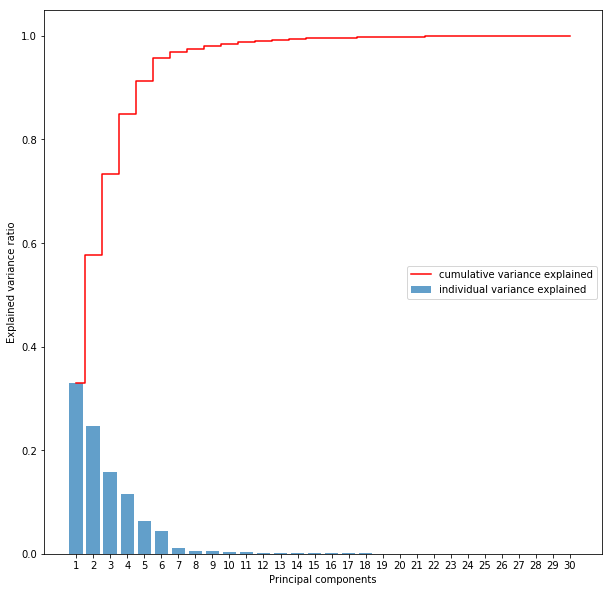

PC1 Cumulative variance: 33.038%
PC2 Cumulative variance: 57.673%
PC3 Cumulative variance: 73.415%
PC4 Cumulative variance: 84.942%
PC5 Cumulative variance: 91.322%
PC6 Cumulative variance: 95.782%
PC7 Cumulative variance: 96.897%
PC8 Cumulative variance: 97.482%
PC9 Cumulative variance: 98.026%
PC10 Cumulative variance: 98.418%
PC11 Cumulative variance: 98.779%
PC12 Cumulative variance: 99.025%
PC13 Cumulative variance: 99.200%
PC14 Cumulative variance: 99.351%
PC15 Cumulative variance: 99.494%
PC16 Cumulative variance: 99.606%
PC17 Cumulative variance: 99.677%
PC18 Cumulative variance: 99.737%
PC19 Cumulative variance: 99.790%
PC20 Cumulative variance: 99.832%
PC21 Cumulative variance: 99.858%
PC22 Cumulative variance: 99.877%
PC23 Cumulative variance: 99.893%
PC24 Cumulative variance: 99.904%
PC25 Cumulative variance: 99.915%
PC26 Cumulative variance: 99.925%
PC27 Cumulative variance: 99.935%
PC28 Cumulative variance: 99.942%
PC29 Cumulative variance: 99.949%
PC30 Cumulative varianc

In [50]:
pca = PCA(n_components=30)
pca.fit(train_df_scaled)

var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10,10))
plt.bar(range(1,len(cum_var_exp)+1), var_exp, align= 'center', label= 'individual variance explained', alpha = 0.7)
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where = 'mid' , label= 'cumulative variance explained', color= 'red')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(np.arange(1,len(var_exp)+1,1))
plt.legend(loc='center right')
plt.show()

# Cumulative variance explained
for i, sum in enumerate(cum_var_exp):
    print("PC" + str(i+1), "Cumulative variance: %.3f% %" %(cum_var_exp[i]*100))

In [51]:
inc_pca = IncrementalPCA(n_components=18)
train_df_pca = inc_pca.fit_transform(train_df_scaled)
train_df_pca = pd.DataFrame(train_df_pca)
print(train_df_pca.shape)

test_df_pca = inc_pca.transform(test_df_scaled)
test_df_pca = pd.DataFrame(test_df_pca)
print(test_df_pca.shape)

(116057, 18)
(35866, 18)


### Feature Selection

In [52]:
print(train_df_pca.columns.values)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [80]:
cat_var = ['source', 'loan_purpose', 'number_of_borrowers', 'loan_term_bin', 'financial_institution_bin', \
           'origination_month', 'first_payment_month', 'insurance_percent_bin','interest_rate_bin',\
           'unpaid_principal_bal_bin','loan_to_value_bin','debt_to_income_ratio_bin',\
           'borrower_credit_score_bin','co-borrower_credit_score_bin']

m_var = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']
m_extra_var = ['is_delinquent','delinquent_sum','delinquent_count','is_delinquent_m12','last_delinquent']

X_train = pd.concat([train_df_pca, train_df[cat_var + m_var + m_extra_var]], axis=1)
Y_train = train_df['m13']

X_test = pd.concat([test_df_pca, test_df[cat_var + m_var + m_extra_var]], axis=1)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(116057, 49) (116057,)
(35866, 49)


In [81]:
# Fit the XGBoost model with default params
xgb = XGBClassifier(n_jobs=-1, nthread=10,random_state=0)
xgb.fit(X_train, Y_train)

# Check the feature importance score for each feature
feature_imp_df = pd.DataFrame({'Feature':X_train.columns, 'Score':xgb.feature_importances_})
# Order the features by max score
feature_imp_df = feature_imp_df.sort_values('Score', ascending=False).reset_index()
feature_imp_df.head(50)

,index,Feature,Score
0,43,m12,0.197448
1,48,last_delinquent,0.142128
2,44,is_delinquent,0.121236
3,45,delinquent_sum,0.087815
4,46,delinquent_count,0.037476
5,38,m7,0.026210
6,31,co-borrower_credit_score_bin,0.025204
7,5,5,0.020464
8,35,m4,0.019423
9,29,debt_to_income_ratio_bin,0.019358


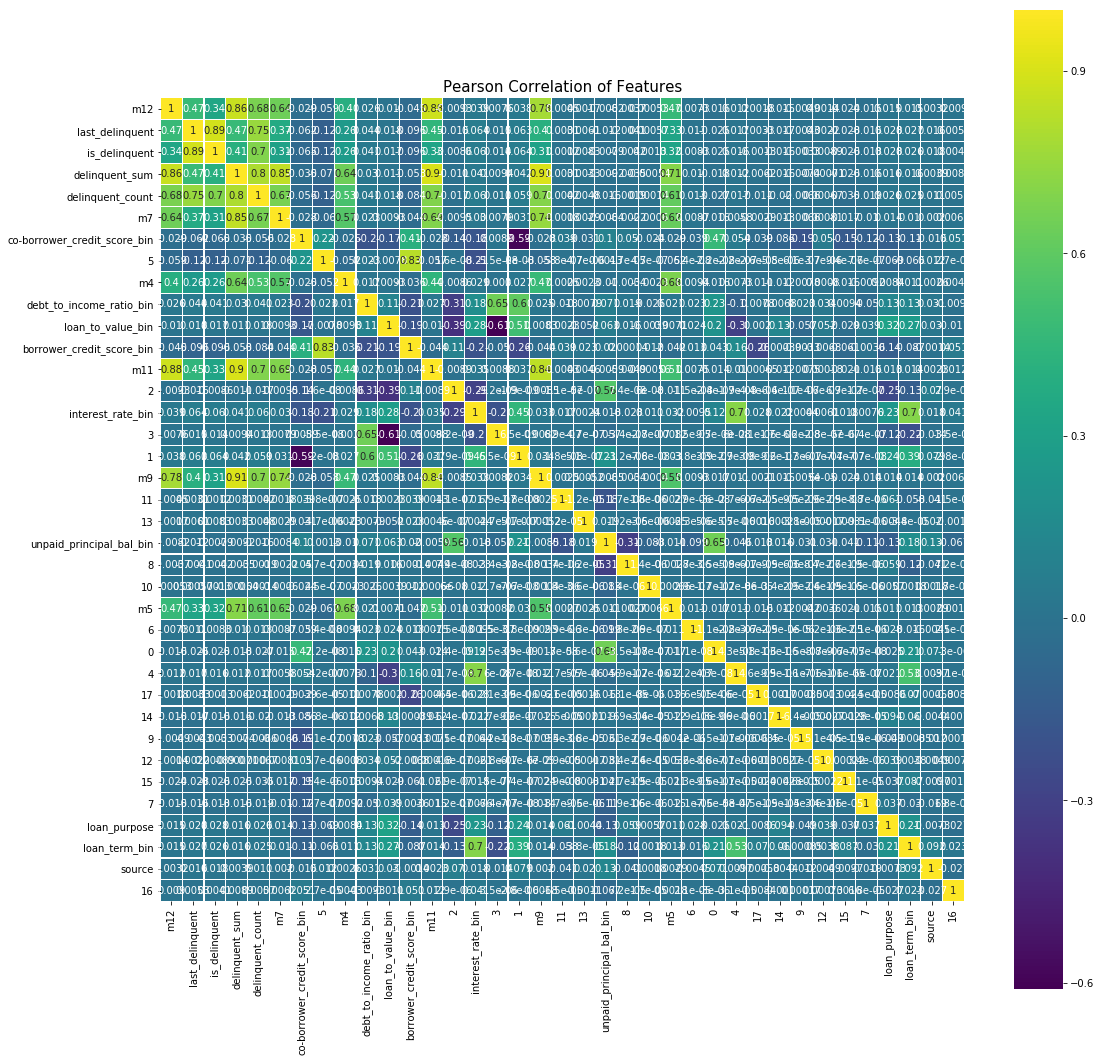

In [82]:
top_features = feature_imp_df[:37]['Feature']

colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', size=15)

sns.heatmap(X_train[top_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

#### Check for Multicollinearity

In [83]:
top_features = feature_imp_df[:37]['Feature']

# Create correlation matrix
corr_matrix = X_train[top_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
cols_to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
print(len(cols_to_drop))
print(cols_to_drop)

7
['is_delinquent', 'delinquent_sum', 'delinquent_count', 'm7', 'borrower_credit_score_bin', 'm11', 'm9']


In [84]:
top_features = [col for col in top_features if col not in ['is_delinquent', 'delinquent_sum','borrower_credit_score_bin']]
print(top_features)

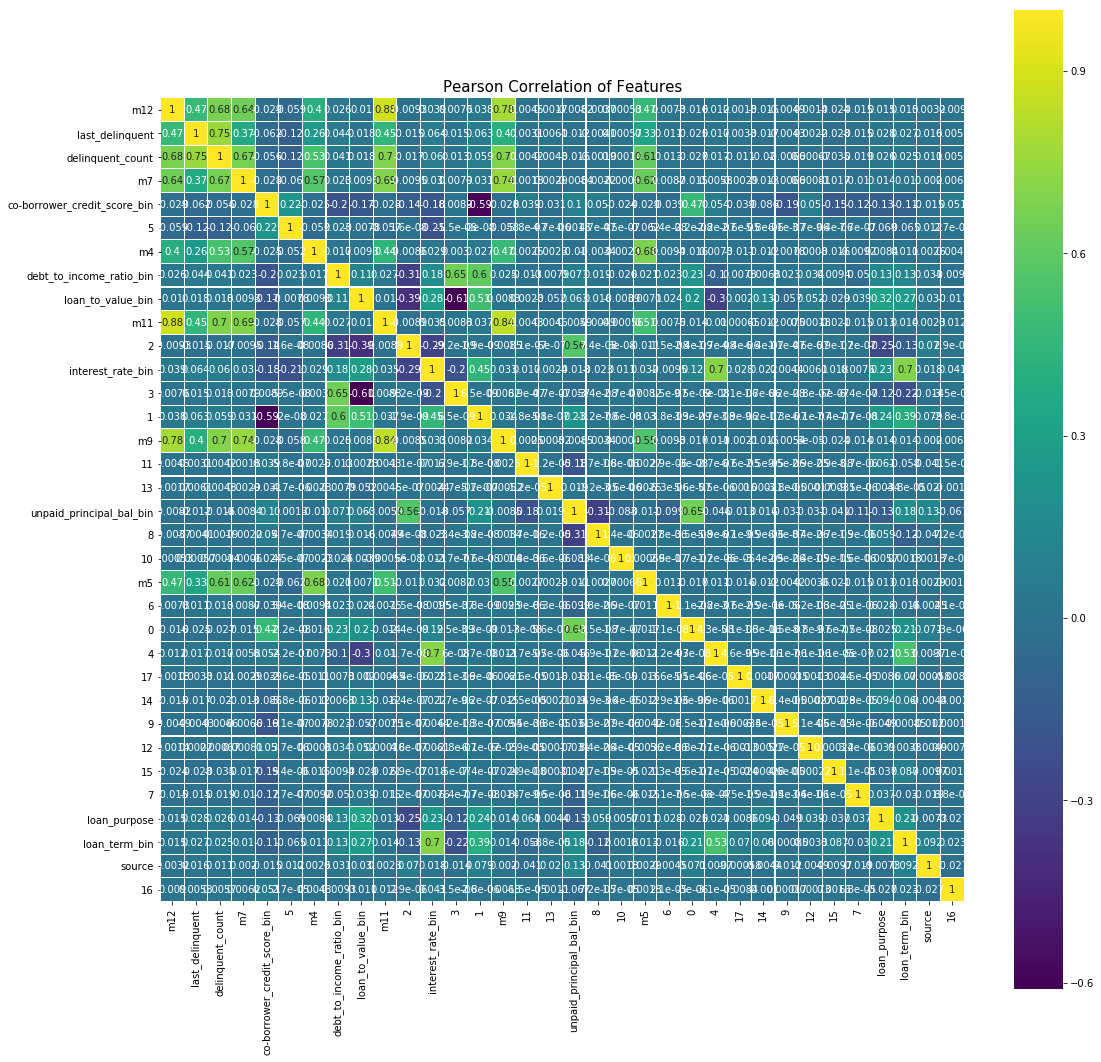

In [85]:
colormap = plt.cm.viridis
plt.figure(figsize=(18,18))
plt.title('Pearson Correlation of Features', size=15)

sns.heatmap(X_train[top_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### KMeans

Text(0.5, 1.0, 'Elbow Curve')

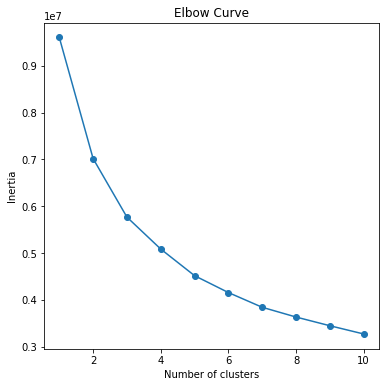

In [68]:
max_clusters = 10
SSE = []
for cluster in range(1,max_clusters+1):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_df_pca)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,max_clusters+1), 'SSE':SSE})
plt.figure(figsize=(6,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

In [87]:
min_clusters = 2
max_clusters = 6
for cluster in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(train_df_pca)
    Y_trn_pred = kmeans.predict(train_df_pca)
    Y_tst_pred = kmeans.predict(test_df_pca)
    train_df['KMeans_'+str(cluster)] = Y_trn_pred
    test_df['KMeans_'+str(cluster)] = Y_tst_pred

### KModes

Text(0.5, 1.0, 'Elbow Curve')

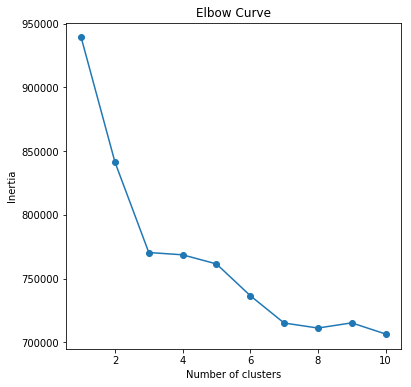

In [72]:
cat_var = ['source', 'loan_purpose', 'number_of_borrowers', 'loan_term_bin', 'financial_institution_bin', \
           'origination_month', 'first_payment_month', 'insurance_percent_bin','interest_rate_bin',\
           'unpaid_principal_bal_bin','loan_to_value_bin','debt_to_income_ratio_bin',\
           'borrower_credit_score_bin','co-borrower_credit_score_bin']

m_var = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']
m_extra_var = ['is_delinquent','delinquent_sum','delinquent_count','is_delinquent_m12','last_delinquent']

max_clusters = 10
SSE = []
for cluster in range(1,max_clusters+1):
    kmod = kmodes.KModes(n_jobs = -1, n_clusters = cluster, init = "Cao", n_init = 1, verbose=1)
    kmod.fit_predict(train_df[cat_var + m_var + m_extra_var])
    SSE.append(kmod.cost_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,max_clusters+1), 'SSE':SSE})
plt.figure(figsize=(6,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')

In [88]:
min_clusters = 2
max_clusters = 6
for cluster in range(min_clusters, max_clusters+1):
    kmod = kmodes.KModes(n_jobs = -1, n_clusters = cluster, init = "Cao", n_init = 1, verbose=1)
    kmod.fit(train_df[cat_var + m_var + m_extra_var])
    Y_trn_pred = kmod.predict(train_df[cat_var + m_var + m_extra_var])
    Y_tst_pred = kmod.predict(test_df[cat_var + m_var + m_extra_var])
    train_df['KMode_'+str(cluster)] = Y_trn_pred
    test_df['KMode_'+str(cluster)] = Y_tst_pred

### Baseline Models

In [93]:
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']

X_train = pd.concat([X_train[top_features], train_df[k_cols]], axis=1)
Y_train = train_df['m13']

x_trn, x_tst, y_trn, y_tst = train_test_split(X_train, Y_train, test_size=0.3, random_state=42) 

X_test = pd.concat([X_test[top_features], test_df[k_cols]], axis=1)

print(X_train.shape, Y_train.shape)
print(x_trn.shape, y_trn.shape)
print(x_tst.shape, y_tst.shape)
print(X_test.shape)

(116057, 44) (116057,)
(81239, 44) (81239,)
(34818, 44) (34818,)
(35866, 44)


In [94]:
def model_cross_validation(estimator, X, y, num_folds=5, scoring='accuracy'):
    start_time = time()
    # scoring = ['accuracy','f1_weighted','precision_weighted','recall_weighted']
    
    kfold = StratifiedKFold(n_splits=num_folds, random_state=42)
    score = cross_val_score(estimator, X, y, scoring=scoring, cv=kfold, n_jobs=-1)
    
    time_elapsed = time() - start_time
    print(estimator.__class__.__name__, '-' ,scoring,':', str(round(100 * score.mean(), 2)) + '% (+/-)', round(score.std() * 2, 4), ', Time taken(sec) :', round(time_elapsed,2))

In [ ]:
#sel_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
#m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']
#m_extra_var = ['is_delinquent']

model_cross_validation(LogisticRegression(), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(KNeighborsClassifier(), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(MultinomialNB(), X_train[sel_cols+m_cols+m_extra_var], Y_train, 10, 'f1_weighted')
model_cross_validation(GaussianNB(), X_train, Y_train, 10, 'f1_weighted')
model_cross_validation(ExtraTreesClassifier(n_jobs=-1), X_train, Y_train, 10, 'f1_weighted')
model_cross_validation(XGBClassifier(n_jobs=-1), X_train, Y_train, 10, 'f1_weighted')
model_cross_validation(LGBMClassifier(n_jobs=-1), X_train, Y_train, 10, 'f1_weighted')
model_cross_validation(SGDClassifier(), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64, 32, 16)), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(SVC(kernel='rbf'), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(SVC(kernel='poly'), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(SVC(kernel='sigmoid'), X_train, Y_train, 10, 'f1_weighted')
#model_cross_validation(LinearSVC(), X_train, Y_train, 10, 'f1_weighted')

##### MultinomialNB

In [95]:
cat_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','is_delinquent']
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']

model_cross_validation(MultinomialNB(), train_df[cat_cols + m_cols + k_cols], Y_train, 10, 'f1_weighted')

MultinomialNB - f1_weighted : 99.25% (+/-) 0.0012 , Time taken(sec) : 1.86


In [96]:
cat_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','is_delinquent']
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']

x_trn1, x_tst1, y_trn1, y_tst1 = train_test_split(train_df[cat_cols + m_cols + k_cols], Y_train, test_size=0.3, random_state=42)

est = MultinomialNB()
est.fit(x_trn1, y_trn1)
y_pred = est.predict(x_tst1)
meu.display_model_performance_metrics(true_labels=y_tst1, predicted_labels=y_pred, classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.991
Precision: 0.9937
Recall: 0.991
F1 Score: 0.9922

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     34621
           1       0.33      0.55      0.41       197

   micro avg       0.99      0.99      0.99     34818
   macro avg       0.66      0.77      0.70     34818
weighted avg       0.99      0.99      0.99     34818


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   0    1
Actual: 0      34396  225
        1         88  109


C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


### Hyperpameter Tuning 

In [170]:
def model_tuning(estimator, X_train, Y_train, X_test, Y_test, params, n_iter=5, num_folds=5, scoring='accuracy'):

        kfold = StratifiedKFold(n_splits=num_folds, random_state=42)

        # define the pipe
        pipe = Pipeline([
            #('scaler', SelectiveScaler()),
            #('pca', SelectivePCA(weight=True)),
            ('est', estimator)
        ])

        # define hyper parameters
#        params = {
#            'scaler__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
#            'pca__whiten': [True, False],
#            'pca__weight': [True, False],
#            'pca__n_components': uniform(0.75, 0.15),
#            'rf__n_estimators': randint(5, 10),
#            'rf__max_depth': randint(5, 15)
#        }

        start_time = time()
        
        # define the grid
        grid = RandomizedSearchCV(pipe, params, n_iter=n_iter, scoring=scoring, n_jobs=-1, cv=kfold, random_state=42)
        #grid = GridSearchCV(pipe, params, scoring=scoring, n_jobs=-1, cv=kfold, random_state=42)

        # fit the grid
        grid.fit(X_train, Y_train)

        # get predictions
        #trn_pred, tst_pred = grid.predict(X_train), grid.predict(X_test)

        # evaluate score
        #trn_acc_scr, tst_acc_scr = accuracy_score(Y_train, trn_pred), accuracy_score(Y_test, tst_pred)

        print(estimator.__class__.__name__,'grid search took %.3f seconds' %(time()-start_time) )
        
        print('-------Grid scores----------')
        means = grid.cv_results_['mean_test_score']
        stds = grid.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, grid.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))        
        
        # Best score and best parameters
        #print('-------Accuracy score----------')
        #print('Train Accuracy:',trn_acc_scr, ', Test Accuracy:', tst_acc_scr)
        print('-------Best score----------')
        print(grid.best_score_ * 100.0)
        print('-------Best params----------')
        print(grid.best_params_)

##### LogisticRegression

In [ ]:
params = {
    'est__penalty' : ['l1', 'l2'],
    'est__C' : [0.0001, 0.001, 0.10, 0.1, 10, 100, 1000],
    'est__solver' : ['liblinear']
}

estimator = LogisticRegression(class_weight='balanced')
model_tuning(estimator, x_trn, y_trn, x_tst, y_tst, params, n_iter=5, num_folds=10, scoring='f1_weighted')

In [97]:
est = LogisticRegression(class_weight='balanced', solver= 'liblinear', penalty= 'l2', C= 0.1)
est.fit(x_trn, y_trn)
y_pred = est.predict(x_tst)
meu.display_model_performance_metrics(true_labels=y_tst, predicted_labels=y_pred, classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.9164
Precision: 0.9929
Recall: 0.9164
F1 Score: 0.9513

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     34621
           1       0.05      0.73      0.09       197

   micro avg       0.92      0.92      0.92     34818
   macro avg       0.52      0.82      0.52     34818
weighted avg       0.99      0.92      0.95     34818


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0      31764  2857
        1         54   143


C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


##### ExtraTrees

In [ ]:
params = {
    'est__n_estimators': [100,300,500], # number of estimators
    #'est__criterion': ['gini', 'entropy'],   # Splitting criterion
    'est__min_samples_split':[3,4,5,6,7,8,9,10], # min_child_weight used at each split
    'est__max_depth': [2,3,4,5,6,7], # Max depth of the trees
}

estimator = ExtraTreesClassifier(n_jobs=-1, class_weight='balanced')
model_tuning(estimator, x_trn, y_trn, x_tst, y_tst, params, n_iter=5, num_folds=10, scoring='f1_weighted')

In [98]:
est = ExtraTreesClassifier(n_jobs=-1, class_weight='balanced', n_estimators=300, min_samples_split= 9, max_depth= 2)
est.fit(x_trn, y_trn)
y_pred = est.predict(x_tst)
meu.display_model_performance_metrics(true_labels=y_tst, predicted_labels=y_pred, classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.9332
Precision: 0.9929
Recall: 0.9332
F1 Score: 0.9605

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     34621
           1       0.06      0.71      0.11       197

   micro avg       0.93      0.93      0.93     34818
   macro avg       0.53      0.82      0.54     34818
weighted avg       0.99      0.93      0.96     34818


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0      32353  2268
        1         57   140


C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:61: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Sai\ML&AI\Kaggle Victory\AV_LoanDelinquency_India_ML\model_evaluation_utils.py:63: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


##### XGBoost

In [ ]:
params = {
    'est__n_estimators': [100,300,500], # number of estimators
    #'est__criterion': ['gini', 'entropy'],   # Splitting criterion
    'est__min_child_weight':[3,4,5], # min_child_weight used at each split
    'est__max_depth': [3,5,7,8,9,10], # Max depth of the trees
}

estimator = XGBClassifier(n_jobs=-1, nthread=10, objective="binary:logistic")
model_tuning(estimator, x_trn, y_trn, x_tst, y_tst, params, n_iter=5, num_folds=10, scoring='f1_weighted')

In [99]:
est = XGBClassifier(n_jobs=-1, nthread=10, objective="binary:logistic", scale_pos_weight = 99.5, n_estimators=100, min_child_weight= 4, max_depth= 10)
est.fit(x_trn, y_trn)
y_pred = est.predict(x_tst)
meu.display_model_performance_metrics(true_labels=y_tst, predicted_labels=y_pred, classes=[0, 1])

Model Performance metrics:
------------------------------
Accuracy: 0.9949
Precision: 0.9944
Recall: 0.9949
F1 Score: 0.9946

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34621
           1       0.56      0.45      0.50       197

   micro avg       0.99      0.99      0.99     34818
   macro avg       0.78      0.72      0.75     34818
weighted avg       0.99      0.99      0.99     34818


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0      34552  69
        1        108  89


##### SVC

In [ ]:
'''
#params = {
#    #'est__kernel': ['rbf','poly', 'linear'], 
#    'est__gamma':[0.1, 1, 10, 100], 
#    'est__C': [0.1, 1, 10, 100, 1000]
#    #'est__degree': [0, 1, 2, 3]
#}

#estimator = SVC(kernel='rbf', class_weight='balanced')

#params = [
#            {'est__kernel': ['rbf'], 'est__gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'est__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
#            {'est__kernel': ['sigmoid'], 'est__gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'est__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
#            {'est__kernel': ['linear'], 'est__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
#         ]

params = [
            {'est__kernel': ['rbf'], 'est__gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'est__C': [0.1, 10, 100, 1000]},
            {'est__kernel': ['poly'], 'est__degree': [0, 1, 2, 3]},
            {'est__kernel': ['sigmoid'], 'est__gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'est__C': [0.1, 10, 100, 1000]},
            {'est__kernel': ['linear'], 'est__C': [0.1, 10, 100, 1000]}
         ]

estimator = SVC(class_weight='balanced')
model_tuning(estimator, X_trn, Y_trn, X_tst, Y_tst, params, n_iter=5, num_folds=10, scoring='f1_weighted')
'''

##### DNN

In [100]:
def dnn_perf_plot(history, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    t = f.suptitle('Deep Neural Net Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epochs = list(range(1,11))
    ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
    ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
    ax1.set_xticks(epochs)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epochs, history.history['loss'], label='Train Loss')
    ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(epochs)
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

##### DNN 4 layers 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81239 samples, validate on 34818 samples
Epoch 1/10
81239/81239 [==============================] - 17s 208us/step - loss: 1.5941 - acc: 0.9881 - val_loss: 0.8727 - val_acc: 0.9894
Epoch 2/10
81239/81239 [==============================] - 16s 195us/step - loss: 1.4750 - acc: 0.9902 - val_loss: 0.8159 - val_acc: 0.9926
Epoch 3/10
81239/81239 [==============================] - 16s 196us/step - loss: 1.4785 - acc: 0.9905 - val_loss: 0.6105 - val_acc: 0.9932
Epoch 4/10
81239/81239 [==============================] - 16s 192us/step - loss: 1.4303 - acc: 0.9908 - val_loss: 0.4678 - val_acc: 0.9930
Epoch 5/10
81239/81239 [==============================] - 16s 194us/step - loss: 1.3700 - acc: 0.9915 - val_loss: 0.3566 - val_acc: 0.9937
Epoch 6/10
81239/81239 [==============================] - 16s 197us/step - loss: 1.4166 - acc: 0.9913 - val_loss: 0.5669 - val_acc: 0.9

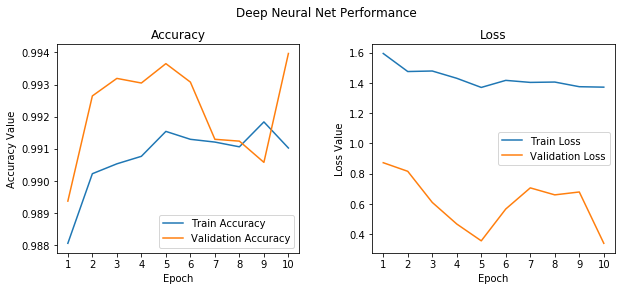

In [102]:
dnn_model = Sequential()
dnn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(32, activation='relu'))
#dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(16, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

weight_save_callback = ModelCheckpoint('output/dnn1_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, 
                                       save_best_only=False, mode='auto')

epochs = 10
history = dnn_model.fit(X_train, Y_train, class_weight={0:10, 1:90}, 
                        epochs=10, batch_size=5, shuffle=True, validation_split=0.3,callbacks=[weight_save_callback], verbose=1)

dnn_perf_plot(history, epochs)

In [106]:
dnn_saved_model = load_model('output/dnn1_weights.05-0.36.hdf5') 
est = dnn_saved_model
#est = dnn_model
est.fit(x_trn, y_trn)
y_pred = est.predict_classes(x_tst)
meu.display_model_performance_metrics(true_labels=y_tst, predicted_labels=y_pred, classes=[0, 1])

Epoch 1/1
81239/81239 [==============================] - 3s 34us/step - loss: 0.0320 - acc: 0.9934
Model Performance metrics:
------------------------------
Accuracy: 0.9947
Precision: 0.9944
Recall: 0.9947
F1 Score: 0.9946

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34621
           1       0.54      0.48      0.51       197

   micro avg       0.99      0.99      0.99     34818
   macro avg       0.77      0.74      0.75     34818
weighted avg       0.99      0.99      0.99     34818


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0      34541  80
        1        103  94


### Model Ensemble - Level 1

In [139]:
meta_features_train = pd.DataFrame()
meta_features_test = pd.DataFrame()

In [145]:
def model_prediction(name, estimator, X_train, Y_train, X_test):
    estimator.fit(X_train, Y_train)
    if pd.Series(name).str.contains('DNN').any():
        Y_trn_pred = estimator.predict_classes(X_train)
        Y_tst_pred = estimator.predict_classes(X_test)
    else:
        Y_trn_pred = estimator.predict(X_train)
        Y_tst_pred = estimator.predict(X_test)
        
    meta_features_train[name] = Y_trn_pred
    meta_features_test[name] = Y_tst_pred
    
    print('---------'+name+'---------')
    print(Counter(meta_features_train[name]))
    print(Counter(meta_features_test[name]))
    
#    Y_trn_pred = estimator.predict_proba(X_train)
#    Y_tst_pred = estimator.predict_proba(X_test)
    
#    if pd.Series(name).str.contains('DNN').any():
#        meta_features_train[name+'_0'] = 1 - Y_trn_pred[:,0]
#        meta_features_train[name+'_1'] = Y_trn_pred[:,0]
#        meta_features_test[name+'_0'] = 1 - Y_tst_pred[:,0]
#        meta_features_test[name+'_1'] = Y_tst_pred[:,0]
#    else:
#        meta_features_train[name+'_0'] = Y_trn_pred[:,0]
#        meta_features_train[name+'_1'] = Y_trn_pred[:,1]
#        meta_features_test[name+'_0'] = Y_tst_pred[:,0]
#        meta_features_test[name+'_1'] = Y_tst_pred[:,1]

In [ ]:
'''
_0_cols = meta_features_train.columns[pd.Series(meta_features_train.columns).str.contains('_0')]
_1_cols = meta_features_train.columns[pd.Series(meta_features_train.columns).str.contains('_1')]

name = 'MEAN'
meta_features_train[name+'_0'] = meta_features_train[_0_cols].mean(axis=1)
meta_features_train[name+'_1'] = meta_features_train[_1_cols].mean(axis=1)
meta_features_test[name+'_0'] = meta_features_test[_0_cols].mean(axis=1)
meta_features_test[name+'_1'] = meta_features_test[_1_cols].mean(axis=1)
'''

In [ ]:
'''
Y_trn_pred = meta_features_train['MEAN_0'].apply(lambda x : 0 if x < 0.5 else 1)
Y_tst_pred = meta_features_test['MEAN_0'].apply(lambda x : 0 if x < 0.5 else 1)
print(Counter(Y_trn_pred))
print(Counter(Y_tst_pred))
'''

In [154]:
# Define base learners
cat_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','is_delinquent']
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']

est = MultinomialNB()
model_prediction('MNB', est, train_df[cat_cols+m_cols+k_cols], train_df['m13'], test_df[cat_cols+m_cols+k_cols])

#est = LogisticRegression(class_weight='balanced', solver= 'liblinear', penalty= 'l2', C= 0.1)
#model_prediction('LR', est, X_train, Y_train, X_test)

#est = ExtraTreesClassifier(n_jobs=-1, class_weight='balanced', n_estimators=300, min_samples_split= 9, max_depth= 2)
#model_prediction('EXT', est, X_train, Y_train, X_test)

est = XGBClassifier(n_jobs=-1, nthread=10, objective="binary:logistic", scale_pos_weight = 99.5, n_estimators=100, min_child_weight= 4, max_depth= 10)
model_prediction('XGB', est, X_train, Y_train, X_test)

est = load_model('output/dnn1_weights.05-0.36.hdf5')
model_prediction('DNN', est, X_train, Y_train, X_test)

---------MNB---------
Counter({0: 114995, 1: 1062})
Counter({0: 35581, 1: 285})
---------XGB---------
Counter({0: 115293, 1: 764})
Counter({0: 35688, 1: 178})
Epoch 1/1
116057/116057 [==============================] - 6s 49us/step - loss: 0.0295 - acc: 0.9939
---------DNN---------
Counter({0: 115616, 1: 441})
Counter({0: 35742, 1: 124})


In [146]:
# Define meta-learner
sel_cols = ['MNB','XGB','DNN']

#estimator = LogisticRegression(penalty="l2", C=100, fit_intercept=True)
est = BernoulliNB()
model_prediction('BNB', est, meta_features_train[sel_cols], Y_train, meta_features_test[sel_cols])

---------BNB---------
Counter({0: 115293, 1: 764})
Counter({0: 35688, 1: 178})


In [147]:
stack1_results_df = pd.DataFrame({'loan_id':test_df['loan_id'],'m13':meta_features_train['BNB']})
stack1_results_df.head()

# Submission1 : 0.330097087378641
stack1_results_df.to_csv('result/stack1_results_df1.csv', index=False)

### Level 2

##### DNN 5 layers 

Train on 81239 samples, validate on 34818 samples
Epoch 1/10
81239/81239 [==============================] - 199s 2ms/step - loss: 1.0852 - acc: 0.9824 - val_loss: 0.0169 - val_acc: 0.9989
Epoch 2/10
81239/81239 [==============================] - 201s 2ms/step - loss: 0.4044 - acc: 0.9918 - val_loss: 0.0382 - val_acc: 0.9983
Epoch 3/10
81239/81239 [==============================] - 202s 2ms/step - loss: 0.2630 - acc: 0.9970 - val_loss: 0.0484 - val_acc: 0.9984
Epoch 4/10
81239/81239 [==============================] - 202s 2ms/step - loss: 0.2234 - acc: 0.9969 - val_loss: 0.0433 - val_acc: 0.9988
Epoch 5/10
81239/81239 [==============================] - 198s 2ms/step - loss: 0.1992 - acc: 0.9979 - val_loss: 0.0393 - val_acc: 0.9990
Epoch 6/10
81239/81239 [==============================] - 201s 2ms/step - loss: 0.2144 - acc: 0.9985 - val_loss: 0.0409 - val_acc: 0.9990
Epoch 7/10
81239/81239 [==============================] - 201s 2ms/step - loss: 0.1025 - acc: 0.9987 - val_loss: 0.0433 - 

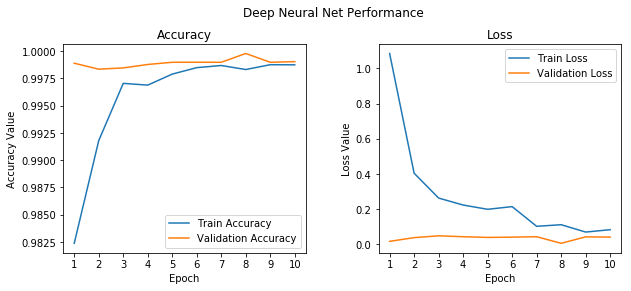

In [149]:
sel_cols2 = ['MNB','XGB','DNN','BNB']

dnn_model = Sequential()
dnn_model.add(Dense(1024, activation='relu', input_shape=(pd.concat([X_train, meta_features_train[sel_cols2]], axis=1).shape[1],)))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(512, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(256, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(BatchNormalization())
dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(8, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

weight_save_callback = ModelCheckpoint('output/dnn2_weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, 
                                       save_best_only=False, mode='auto')

epochs = 10
history = dnn_model.fit(pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, class_weight={0:10, 1:90}, 
                        epochs=10, batch_size=5, shuffle=True, validation_split=0.3,callbacks=[weight_save_callback], verbose=1)

dnn_perf_plot(history, epochs)

##### SVC-RBF

In [ ]:
sel_cols2 = ['MNB','XGB','DNN','BNB']

x_trn2, x_tst2, y_trn2, y_tst2 = train_test_split(pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, test_size=0.3, random_state=42) 

print(x_trn2.shape, y_trn2.shape)
print(x_tst2.shape, y_tst2.shape)

params = {'est__kernel': ['rbf'], 'est__gamma': [1e-3,1e-4], 'est__C': [0.01, 0.1, 10]}
#params = {'est__kernel': ['poly'], 'est__degree': [2, 3]}
        #{'est__kernel': ['sigmoid'], 'est__gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'est__C': [0.1, 10, 100, 1000]},
        #{'est__kernel': ['linear'], 'est__C': [0.1, 10, 100, 1000]}

estimator = SVC(class_weight='balanced')
model_tuning(estimator, x_trn2, y_trn2, x_tst2, y_tst2, params, n_iter=5, num_folds=10, scoring='f1_weighted')

In [155]:
# Define base learners
cat_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','is_delinquent']
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']
sel_cols2 = ['MNB','XGB','DNN','BNB']

est = MultinomialNB()
model_prediction('MNB2', est, pd.concat([train_df[cat_cols+m_cols+k_cols], meta_features_train[sel_cols2]], axis=1), train_df['m13'], 
                 pd.concat([test_df[cat_cols+m_cols+k_cols], meta_features_test[sel_cols2]], axis=1))

est = XGBClassifier(n_jobs=-1, nthread=10, objective="binary:logistic", scale_pos_weight = 99.5, n_estimators=100, min_child_weight= 4, max_depth= 10)
model_prediction('XGB2', est, pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, 
                 pd.concat([X_test, meta_features_test[sel_cols2]], axis=1))

est = load_model('output/dnn2_weights.09-0.04.hdf5') 
model_prediction('DNN2', est, pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, 
                 pd.concat([X_test, meta_features_test[sel_cols2]], axis=1))

---------MNB2---------
Counter({0: 114780, 1: 1277})
Counter({0: 35560, 1: 306})
---------XGB2---------
Counter({0: 115326, 1: 731})
Counter({0: 35689, 1: 177})
Epoch 1/1
116057/116057 [==============================] - 54s 465us/step - loss: 0.0047 - acc: 0.9989
---------DNN2---------
Counter({0: 115293, 1: 764})
Counter({0: 35688, 1: 178})


In [155]:
# Define base learners
#cat_cols = [ 'source', 'loan_purpose', 'number_of_borrowers', 'origination_month' ]
cat_cols = ['is_delinquent','last_delinquent', 'delinquent_count', 'co-borrower_credit_score_bin', 'debt_to_income_ratio_bin', 
            'loan_to_value_bin', 'interest_rate_bin', 'unpaid_principal_bal_bin', 'loan_purpose', 'loan_term_bin', 'source']
m_cols = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']
k_cols = ['KMeans_2','KMeans_3','KMeans_4','KMeans_5','KMeans_6','KMode_2','KMode_3','KMode_4','KMode_5','KMode_6']
sel_cols2 = ['MNB','XGB','DNN','BNB']

est = MultinomialNB()
model_prediction('MNB2', est, pd.concat([train_df[cat_cols+m_cols+k_cols], meta_features_train[sel_cols2]], axis=1), train_df['m13'], 
                 pd.concat([test_df[cat_cols+m_cols+k_cols], meta_features_test[sel_cols2]], axis=1))

est = SVC(class_weight='balanced')
model_prediction('SVC2', est, pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, 
                 pd.concat([X_test, meta_features_test[sel_cols2]], axis=1))

est = load_model('output/dnn2_weights.09-0.04.hdf5') 
model_prediction('DNN2', est, pd.concat([X_train, meta_features_train[sel_cols2]], axis=1), Y_train, 
                 pd.concat([X_test, meta_features_test[sel_cols2]], axis=1))

---------MNB2---------
Counter({0: 114780, 1: 1277})
Counter({0: 35560, 1: 306})
---------XGB2---------
Counter({0: 115326, 1: 731})
Counter({0: 35689, 1: 177})
Epoch 1/1
116057/116057 [==============================] - 54s 465us/step - loss: 0.0047 - acc: 0.9989
---------DNN2---------
Counter({0: 115293, 1: 764})
Counter({0: 35688, 1: 178})


In [165]:
# Define meta-learner
sel_cols2 = ['MNB2','DNN2']

est = BernoulliNB()
model_prediction('BNB2', est, meta_features_train[sel_cols2], Y_train, meta_features_test[sel_cols2])

---------BNB2---------
Counter({0: 115424, 1: 633})
Counter({0: 35695, 1: 171})


In [166]:
stack2_results_df = pd.DataFrame({'loan_id':test_df['loan_id'],'m13':meta_features_test['BNB2']})
stack2_results_df.head()

# Submission1 : 0.334975369458128 - sel_cols2 = ['MNB2','DNN2']
stack2_results_df.to_csv('result/stack2_results_df1.csv', index=False)